In [1]:
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import timeit
from tqdm import tqdm
import transformers

# Handling Data for Training


In [2]:
import pickle

def load_pickle_to_df(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return pd.DataFrame(data)

# train_df = load_pickle_to_df('../data/df_train.pkl')
# val_df = load_pickle_to_df('../data/df_val.pkl')
# test_df = load_pickle_to_df('../data/df_test.pkl')

In [3]:
'''
Is it better to split data up into new rows by the multiple captions or would it be more helpful to a function to iterate over the list inside the df for when creating batches? 
Is this second, harder method actually going to save me from having to convert an image into a tensor -> embedding multiple times over?
Verdict: For now will convert into 5x dataframe for each so that I can just iterate over each value in training. 
'''

#Honestly I could have turned this into a function, but i'm lazy so I just copy-paste this two more times
# train_copy = train_df.copy()
# separated_rows = []
# for _,row in train_copy.iterrows():
#     # print(row['caption'],"\n\n")
#     for idx in range(0,len(row['caption'])):#iterate over caption idx and use it to create new rows
#          #make copy and modify caption, then append that to separated_rows list 
#         # print(row['caption'][idx])
#         dupe = row.copy()
#         dupe['caption'] = row['caption'][idx]
#         dupe['sentids'] = row['sentids'][idx]
#         separated_rows.append(dupe)

# sep_train_df = pd.DataFrame(separated_rows)
# sep_train_df.reset_index(drop=True, inplace=True)
# sep_train_df.head()

'\nIs it better to split data up into new rows by the multiple captions or would it be more helpful to a function to iterate over the list inside the df for when creating batches? \nIs this second, harder method actually going to save me from having to convert an image into a tensor -> embedding multiple times over?\nVerdict: For now will convert into 5x dataframe for each so that I can just iterate over each value in training. \n'

In [4]:
# val_copy = val_df.copy()
# separated_rows = []
# for _,row in val_copy.iterrows():
#     # print(row['caption'],"\n\n")
#     for idx in range(0,len(row['caption'])):#iterate over caption idx and use it to create new rows
#          #make copy and modify caption, then append that to separated_rows list 
#         # print(row['caption'][idx])
#         dupe = row.copy()
#         dupe['caption'] = row['caption'][idx]
#         dupe['sentids'] = row['sentids'][idx]
#         separated_rows.append(dupe)

# sep_val_df = pd.DataFrame(separated_rows)
# sep_val_df.reset_index(drop=True, inplace=True)

# test_copy = test_df.copy()
# separated_rows = []
# for _,row in test_copy.iterrows():
#     # print(row['caption'],"\n\n")
#     for idx in range(0,len(row['caption'])):#iterate over caption idx and use it to create new rows
#          #make copy and modify caption, then append that to separated_rows list 
#         # print(row['caption'][idx])
#         dupe = row.copy()
#         dupe['caption'] = row['caption'][idx]
#         dupe['sentids'] = row['sentids'][idx]
#         separated_rows.append(dupe)

# sep_test_df = pd.DataFrame(separated_rows)
# sep_test_df.reset_index(drop=True, inplace=True)

# #fix the dataframes
# train_df = sep_train_df
# val_df = sep_val_df
# test_df = sep_test_df


In [ ]:
# train_df = load_pickle_to_df("D:/temp_store_programming/image_caption_dataset/separated_train.pkl")
# val_df = load_pickle_to_df("D:/temp_store_programming/image_caption_dataset/separated_val.pkl")
# test_df = load_pickle_to_df("D:/temp_store_programming/image_caption_dataset/separated_test.pkl")

In [6]:
# maximum = 0
# def count_spaces(passage):
#     count = 1
#     for x in passage:
#         if x == ' ':
#             count+=1
#     return count

# for i in train_df['caption']:
#     maximum = max(maximum, count_spaces(i))
#     if count_spaces(i) == 78:
#         print(i)
# print(maximum)

# Import Models for Image and Text Encoding


In [ ]:
device = 'cpu'
# clip_tokenizer = transformers.CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
# # vision_transformer = transformers.ClipModel.from_pretrained('openai/clip-vit-base-patch32')
# # vision_transformer= vision_transformer.vision_model

# vision_transformer = transformers.ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [8]:
params = lambda m: sum(p.numel() for p in m.parameters())
print(f"CLIP: \n {clip_tokenizer}\n\n")
print(f"ViT: \n {vision_transformer}")


CLIP: 
 CLIPTokenizer(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


ViT: 
 ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query)

# ChatGPT constructed Model


In [9]:
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')

# Add special tokens if needed
tokenizer.add_special_tokens({
    'pad_token': '<|endoftext|>',  # This is the default pad, but we make it explicit
    'bos_token': '<|startoftext|>',
    'eos_token': '<|endoftext|>',
    'unk_token': '<|endoftext|>'
})

MAX_LEN = 78

In [10]:
from pathlib import Path
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
# DATA_PATH = Path("D:\huggingface_datasets\nlphuji___flickr30k\TEST\1.1.0\2b239befc81b6e3f035ce6bd52f5f4d60f5625f7")

class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform=image_transform, max_len=78):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = row['image']
        image = self.transform(image)
        
        caption = row['caption']

        encoding = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

In [11]:
from transformers import ViTModel

class ImageEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.linear = torch.nn.Linear(self.vit.config.hidden_size, 512)  # Project to decoder dimension
        self.norm = torch.nn.LayerNorm(512)

    def forward(self, x):
        with torch.no_grad():  # Freeze ViT for now
            outputs = self.vit(x)
            cls_embedding = outputs.last_hidden_state[:, 0]  # CLS token
        return self.norm(self.linear(cls_embedding)).unsqueeze(1)  # (B, 1, 512)


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CustomDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6, dim_ff=2048, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(512, d_model)  # Max sequence length
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True),
            num_layers
        )
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        seq_len = tgt.size(1)
        positions = torch.arange(0, seq_len, device=tgt.device).unsqueeze(0)
        x = self.token_embedding(tgt) * (self.d_model ** 0.5) + self.pos_embedding(positions)
        x = self.dropout(x)
        output = self.transformer_decoder(x, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        return self.fc_out(output)


In [13]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

def create_causal_mask(size):
    # Generates a lower triangular matrix for self-attention masking
    return torch.tril(torch.ones((size, size), dtype=torch.bool))

def train_one_epoch(decoder, image_encoder, dataloader, optimizer, tokenizer, device):
    decoder.train()
    image_encoder.eval()  # Feature extractor frozen
    total_loss = 0
    pad_token_id = tokenizer.pad_token_id

    for batch in tqdm(dataloader, desc="Training"):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)

        # Prepare decoder inputs and targets
        decoder_input = input_ids[:, :-1]  # Exclude last token
        targets = input_ids[:, 1:]         # Exclude first token

        # Get image context
        with torch.no_grad():
            memory = image_encoder(images)  # (B, 1, D)

        tgt_mask = create_causal_mask(decoder_input.size(1)).to(device)

        outputs = decoder(
            tgt=decoder_input,
            memory=memory,
            tgt_mask=tgt_mask
        )

        loss = F.cross_entropy(
            outputs.reshape(-1, outputs.size(-1)),
            targets.reshape(-1),
            ignore_index=pad_token_id
            )


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [14]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate(decoder, image_encoder, dataloader, tokenizer, device):
    decoder.eval()
    image_encoder.eval()
    bleu_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device)
            references = batch['input_ids'].cpu().tolist()

            memory = image_encoder(images)
            predictions = generate_caption(decoder, memory, tokenizer, device)

            for pred, ref in zip(predictions, references):
                # Clean prediction and reference
                ref_caption = tokenizer.decode(ref, skip_special_tokens=True).split()
                bleu = sentence_bleu(
                    [ref_caption],
                    pred.split(),
                    smoothing_function=SmoothingFunction().method1
                )
                bleu_scores.append(bleu)

    return sum(bleu_scores) / len(bleu_scores)


In [15]:
def generate_caption(decoder, memory, tokenizer, device, max_len=78):
    decoder.eval()
    batch_size = memory.size(0)
    generated = torch.full((batch_size, 1), tokenizer.bos_token_id, dtype=torch.long).to(device)

    for _ in range(max_len):
        tgt_mask = create_causal_mask(generated.size(1)).to(device)
        outputs = decoder(generated, memory, tgt_mask=tgt_mask)
        next_token = outputs[:, -1, :].argmax(-1).unsqueeze(1)
        generated = torch.cat((generated, next_token), dim=1)

        # Stop if all sequences produced EOS
        if (next_token == tokenizer.eos_token_id).all():
            break

    captions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated]
    return captions


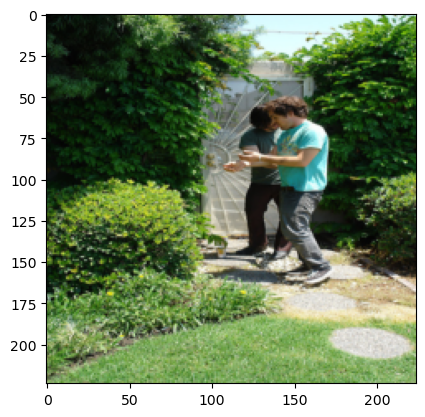

In [16]:
# print("Hello World")

# arr_ = image_transform(train_df['image'][0])

def image_show(img):
    arr_ = image_transform(img)
    # arr_ = np.squeeze(arr_) # you can give axis attribute if you wanna squeeze in specific dimension
    mean = np.array([0.5, 0.5, 0.5])[:, None, None]
    std = np.array([0.5, 0.5, 0.5])[:, None, None]
    arr_ = arr_ * std + mean
    arr_ = np.transpose(arr_, (1, 2, 0))
    plt.imshow(arr_)
    plt.show()

image_show(train_df['image'][0])

In [17]:
# Assuming your data is in train_df, val_df
train_dataset = ImageCaptionDataset(train_df, tokenizer, transform=image_transform)
val_dataset = ImageCaptionDataset(val_df, tokenizer, transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_encoder = ImageEncoder().to(device)
decoder = CustomDecoder(vocab_size=len(tokenizer)).to(device)
decoder.token_embedding.weight.data.normal_(mean=0.0, std=0.02)

optimizer = torch.optim.Adam(decoder.parameters(), lr=3e-4)

# for epoch in range(1, 6):
#     print(f"\nEpoch {epoch}")
#     train_loss = train_one_epoch(decoder, image_encoder, train_loader, optimizer, tokenizer, device)
#     print(f"Train Loss: {train_loss:.4f}")
#     bleu_score = evaluate(decoder, image_encoder, val_loader, tokenizer, device)
#     print(f"Validation BLEU Score: {bleu_score:.4f}")


In [18]:
# batch = next(iter(train_loader))
# print("Image shape:", batch['image'].shape)
# print("Input IDs:", batch['input_ids'].shape)

In [19]:
# dataset = ImageCaptionDataset(train_df, tokenizer, transform=image_transform)

# # Try accessing one sample
# sample = dataset[0]

# print("Image tensor shape:", sample['image'].shape)
# print("Caption tokens:", sample['input_ids'][:10])  # First 10 tokens


In [20]:
def infer_caption(PIL_Image, image_encoder, decoder, tokenizer, device):

    image_tensor = image_transform(PIL_Image).unsqueeze(0).to(device)
    # Extract image features
    with torch.no_grad():
        memory = image_encoder(image_tensor)

    # Start with <BOS> token
    generated = torch.full((1, 1), tokenizer.bos_token_id, dtype=torch.long).to(device)

    for _ in range(78):
        tgt_mask = create_causal_mask(generated.size(1)).to(device)
        output = decoder(generated, memory, tgt_mask=tgt_mask)
        next_token = output[:, -1, :].argmax(-1).unsqueeze(1)
        generated = torch.cat((generated, next_token), dim=1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    caption = tokenizer.decode(generated.squeeze(), skip_special_tokens=True)
    return caption


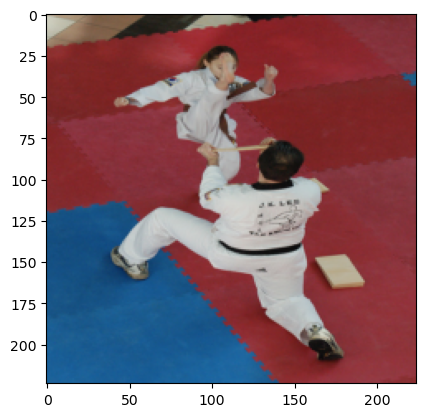

Generated caption: eventprofs ri mcgowan ri matswine eventprofs ri mateventprofs ri eventprofs ri swine eventprofs matmatmateventprofs eventprofs speaker mcgowan matmatri ri onist eventprofs ri clariri bromance matspeaker eventprofs ri ri matmatmcgowan eventprofs ri ri matmateventprofs ri mateventprofs ri matmcgowan eventprofs ri ri ri ri mateventprofs speaker eventprofs ri matri matmateventprofs swine mcgowan mateventprofs ri mcgowan ri ri ri eventprofs ri


In [21]:

caption = infer_caption(test_df['image'][10], image_encoder, decoder, tokenizer, device)
image_show(test_df['image'][10])
print("Generated caption:", caption)

In [22]:
torch.save(image_encoder.state_dict(), "./saved_models/no_train_model")